In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [2]:
train_dir = '/Volumes/T7/herbarium-2022-fgvc9/train_images/'
test_dir = '/Volumes/T7/herbarium-2022-fgvc9/test_images/'

with open('/Volumes/T7/herbarium-2022-fgvc9/train_metadata.json') as json_file:
    train_meta = json.load(json_file)
with open("/Volumes/T7/herbarium-2022-fgvc9/test_metadata.json") as json_file:
    test_meta = json.load(json_file)

In [3]:
image_ids = [image["image_id"] for image in train_meta["images"]]
image_dirs = [train_dir + image['file_name'] for image in train_meta["images"]]
category_ids = [annotation['category_id'] for annotation in train_meta['annotations']]
genus_ids = [annotation['genus_id'] for annotation in train_meta['annotations']]

test_ids = [image['image_id'] for image in test_meta]
test_dirs = [test_dir + image['file_name'] for image in test_meta]

train_df = pd.DataFrame({
    "image_id" : image_ids,
    "image_dir" : image_dirs,
    "category" : category_ids,
    "genus" : genus_ids})

test_df = pd.DataFrame({
    "test_id" : test_ids,
    "test_dir" : test_dirs
})


train_df

,image_id,image_dir,category,genus
0,00000__001,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,0,1
1,00000__002,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,0,1
2,00000__003,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,0,1
3,00000__004,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,0,1
4,00000__005,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,0,1
...,...,...,...,...
839767,15504__032,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,15504,2584
839768,15504__033,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,15504,2584
839769,15504__035,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,15504,2584
839770,15504__036,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,15504,2584


In [4]:
genus_map = {genus['genus_id'] : genus['genus'] for genus in train_meta['genera']}
train_df['genus'] = train_df['genus'].map(genus_map)
train_df

,image_id,image_dir,category,genus
0,00000__001,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,0,Abies
1,00000__002,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,0,Abies
2,00000__003,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,0,Abies
3,00000__004,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,0,Abies
4,00000__005,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,0,Abies
...,...,...,...,...
839767,15504__032,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,15504,Zygophyllum
839768,15504__033,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,15504,Zygophyllum
839769,15504__035,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,15504,Zygophyllum
839770,15504__036,/Volumes/T7/herbarium-2022-fgvc9/train_images/...,15504,Zygophyllum


In [5]:
print('Top 15 Genus ')
print(train_df['genus'].value_counts().head(15))
print()

Top 15 Genus 
Carex           24743
Astragalus      15192
Penstemon       12256
Eriogonum       10063
Erigeron         7135
Euphorbia        7070
Cyperus          6412
Phacelia         6165
Castilleja       5485
Juncus           5440
Quercus          5230
Salix            4946
Crataegus        4890
Rhynchospora     4635
Asclepias        4540
Name: genus, dtype: int64



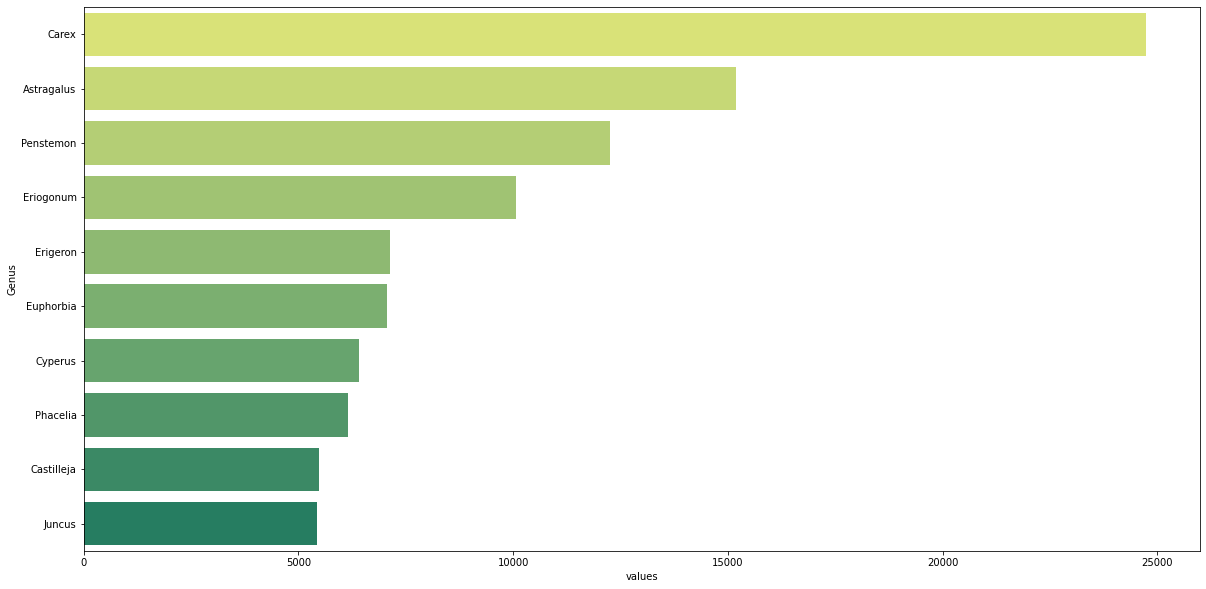

In [6]:
data = train_df['genus'].value_counts().head(10)
data = pd.DataFrame({'Genus' : data.index,
                     'values' : data.values})
plt.figure(figsize = (20, 10))
sns.barplot(x='values', y = 'Genus', data = data , palette='summer_r')
plt.show()

In [7]:
def show_images(speices):
    images = train_df.loc[train_df['genus'] == speices]['image_dir'][:6]
    i = 1
    fig = plt.figure(figsize = (18, 18))
    plt.suptitle(speices, fontsize = '30')
    for image in images:
        img = cv2.imread(image)
        ax = fig.add_subplot(2, 3, i)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_axis_off()
        i += 1
    plt.show()

In [9]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [10]:
BATCH = 32
EPOCHS = 20

LR = 0.002
IM_SIZE = 224

X_Train, Y_Train = train_df['image_dir'].values, train_df['category'].values

Transform = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

In [11]:
class GetData(Dataset):
    def __init__(self, FNames, Labels, Transform):
        self.fnames = FNames
        self.transform = Transform
        self.labels = Labels         
        
    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, index):       
        #x = Image.open(self.fnames[index])
        x = cv2.imread(self.fnames[index])
        
        
        if "train" in self.fnames[index]:             
            return self.transform(x), self.labels[index]
        elif "test" in self.fnames[index]:            
            return self.transform(x), self.fnames[index]
                
trainset = GetData(X_Train, Y_Train, Transform)
trainloader = DataLoader(trainset, batch_size=BATCH, shuffle=True)

N_Classes = train_df['category'].nunique()
next(iter(trainloader))[0].shape

model = torchvision.models.densenet169(pretrained=True)


In [12]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

def split_indices(n, val_pct=0.1, seed=99):
    n_val = int(val_pct*n)
    np.random.seed(seed)
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]

train_indices, val_indices = split_indices(len(trainset))

train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(trainset, batch_size=BATCH, sampler=train_sampler)

val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(trainset, batch_size=BATCH, sampler=val_sampler)


In [13]:
print(model.classifier.in_features) 
print(model.classifier.out_features)

for param in model.parameters():
    param.requires_grad = False
    
n_inputs = model.classifier.in_features
last_layer = nn.Linear(n_inputs, N_Classes)
model.classifier = last_layer

if torch.cuda.is_available():
    model.cuda()
print(model.classifier.out_features)    

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters())

next(model.parameters()).is_cuda

1664
1000
15501


False

In [16]:
#这是另一个model
from resNet9 import ResNet9
torch.cuda.empty_cache()
model1 = ResNet9(3,N_Classes)
model1.to(device)
next(model.parameters()).is_cuda

False

In [18]:
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

from tqdm import tqdm

def train(trainloader, model, criterion, optimizer, scaler, device=torch.device(device)):
    train_acc = 0.0
    train_loss = 0.0
    for images, labels in tqdm(train_dl):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=True):
            output = model(images)
            loss = criterion(output, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        acc = ((output.argmax(dim=1) == labels).float().mean())
        train_acc += acc
        train_loss += loss
        del output
        del loss
    return train_acc/len(trainloader), train_loss/len(trainloader)

In [19]:
def evaluate(testloader, model, criterion, device=torch.device(device)):
    eval_acc = 0.0
    eval_loss = 0.0
    for images, labels in tqdm(val_dl):
        images = images.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            output = model(images)
            loss = criterion(output, labels)

        acc = ((output.argmax(dim=1) == labels).float().mean())
        eval_acc += acc
        eval_loss += loss
        del output
        del loss
  
    return eval_acc/len(testloader), eval_loss/len(testloader)

In [20]:
%%time
##%dirsrmal Training
scaler = torch.cuda.amp.GradScaler(enabled=True)
for epoch in range(EPOCHS):
    train_acc, train_loss = train(train_dl, model1, criterion, optimizer, scaler, device=device)
    torch.save(model.state_dict(), './model.pth')
    #eval_acc, eval_loss = evaluate(val_dl, model, criterion, device=device)
    print("")
    print(f"Epoch {epoch + 1} | Train Acc: {train_acc*100} | Train Loss: {train_loss}")
    #print(f"\t Val Acc: {eval_acc*100} | Val Loss: {eval_loss}")
    print("===="*8)

  0%|          | 0/23619 [00:00<?, ?it/s]/Users/terry/miniconda3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
  0%|          | 0/23619 [00:24<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x25088 and 512x15501)

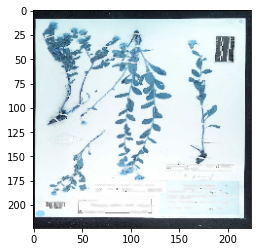

In [ ]:
for image, label in val_dl:
    img = image[0].permute(1,2,0)
    plt.imshow(img)
    break

In [ ]:
model.to('cpu')
torch.save(model.state_dict(), './model.pth')

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
for image, label in val_dl:
    xb = image[0].unsqueeze(0)
    xb = xb.to(device)
    output = model(xb)
    break

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.